In [3]:
import pandas as pd
import re
import numpy as np
from stop_words import get_stop_words
from uk_stemmer import UkStemmer
import tokenize_uk
import matplotlib.pyplot as plt 
import nltk
import pymorphy2
import razdel
from time import time


from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, f1_score
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier, Perceptron, PassiveAggressiveClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier, BaggingClassifier, StackingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import chi2
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

## Loading news in dataframe

In [4]:
categorized_my_file_path = '../data/categorized.csv'
def get_train_data(filepath):
    categorized = pd.read_csv(filepath)
    return categorized[categorized.lang=='uk'], categorized[categorized.lang=='ru']

news_ukr, news_ru = get_train_data(categorized_my_file_path)

### Initialization of stop words, stemmer and lemmatizer for ukrainian and russian

In [5]:
stop_words_ukr = get_stop_words('uk')
stop_words_ru = get_stop_words('ru')

additional_sw_ukr_path = '../dicts/more_stop_words_ukr.txt'
additional_sw_ru_path = '../dicts/more_stop_words_ru.txt'

with open(additional_sw_ukr_path) as f:
    more_stopwords_ukr = [w.strip() for w in f.readlines()]
    
with open(additional_sw_ru_path) as f:
    more_stopwords_ru = [w.strip() for w in f.readlines()]
    
stop_words_ukr += more_stopwords_ukr
stop_words_ru += more_stopwords_ru

stemmer_ru = nltk.stem.snowball.SnowballStemmer("russian") 
stemmer_ukr = UkStemmer()

stemmed_stopwords_ukr = [stemmer_ukr.stem_word(word) for word in stop_words_ukr]
stemmed_stopwords_ru = [stemmer_ru.stem(word) for word in stop_words_ru]

morph_ru = pymorphy2.MorphAnalyzer(lang='ru')
morph_ukr = pymorphy2.MorphAnalyzer(lang='uk')

## Parameters for custom tokenizers for ukrainian an russian

In [6]:
token_pattern = re.compile(r'\w{2,}')

stem_ukr = {"tokenize": tokenize_uk.tokenize_words,
            "stem": stemmer_ukr.stem_word, 
            "stop_words": stemmed_stopwords_ukr,
           "token_pattern": token_pattern}

stem_ru = {"tokenize": lambda text: [_.text for _ in razdel.tokenize(text)],
            "stem": stemmer_ru.stem, 
            "stop_words": stemmed_stopwords_ru,
           "token_pattern": token_pattern}

lemm_ukr = {"tokenize": tokenize_uk.tokenize_words,
            "stem": lambda w: morph_ukr.parse(w)[0].normal_form, 
            "stop_words": stop_words_ukr,
           "token_pattern": token_pattern}

lemm_ru = {"tokenize": lambda text: [_.text for _ in razdel.tokenize(text)],
            "stem": lambda w: morph_ru.parse(w)[0].normal_form, 
            "stop_words": stop_words_ru,
           "token_pattern": token_pattern}

## Functions to split data, get custom tokenizer and features

In [7]:
def split_data(text, label, test_size):
    return train_test_split(text, label, test_size=test_size, stratify = label)


def my_tokenizer(text, tokenize, stem, stop_words, token_pattern):
    text = text.lower()
    tokens = tokenize(text)
    stemmed = [stem(tok) for tok in tokens if ( len(tok)>1 and
                                        token_pattern.match(tok) )]
    return [tok for tok in stemmed if tok not in stop_words]


def get_features(vectorizer, X_train, X_test):
    vectorizer.fit(X_train)
    X_train = vectorizer.transform(X_train)
    X_test = vectorizer.transform(X_test)
    return X_train, X_test, vectorizer.vocabulary_, vectorizer.get_feature_names()

## Split the data and get features

In [8]:
X_train, X_test, y_train, y_test = split_data(news_ukr.all_text, news_ukr.category, 0.3)

In [9]:
tfidf_vec = TfidfVectorizer(tokenizer = lambda text: my_tokenizer(text, **stem_ukr), 
                             max_df=0.9, min_df = 3)

X_train_vec, X_test_vec, vocabulary, feature_names = get_features(tfidf_vec, X_train, X_test)

/Users/oksana/Dev/TextClassification/venv/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


## Check top features for every category

In [10]:
def get_top_features(X_train, y_train, feature_names, N=5):
    for cat in y_train.unique():
        features_chi2 = chi2(X_train, y_train==cat)
        indices = np.argsort(features_chi2[0])
        features = np.array(feature_names)[indices]
        unigrams = [v for v in features if len(v.split(' ')) == 1]
    #     bigrams = [v for v in features if len(v.split(' ')) == 2]
        print("# '{}':".format(cat))
        print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    #     print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

In [16]:
get_top_features(X_train_vec, y_train, feature_names, N=5)

# 'Світ':
  . Most correlated unigrams:
. флойд
. бейрут
. джонсон
. вірмені
. сша
# 'Життя/lifestyle':
  . Most correlated unigrams:
. карт
. знак
. продукт
. свят
. зодіак
# 'Економіка':
  . Most correlated unigrams:
. банк
. курс
. мвф
. млрд
. грн
# 'Політика':
  . Most correlated unigrams:
. порошенк
. верховн
. рад
. депутат
. вакарчук
# 'Шоу-бізнес':
  . Most correlated unigrams:
. лорак
. показал
. instagram
. співачк
. зірк
# 'Інциденти':
  . Most correlated unigrams:
. автомобіл
. поліці
. вибух
. пожеж
. чоловік
# 'Суспільство':
  . Most correlated unigrams:
. мов
. шляхопровод
. оцінюванн
. зно
. стерненк
# 'Спорт':
  . Most correlated unigrams:
. тренер
. ліг
. клуб
. динам
. матч
# 'Карантин':
  . Most correlated unigrams:
. заклад
. послабленн
. украин
. масков
. карантин
# 'Міжнародна політика':
  . Most correlated unigrams:
. трамп
. парад
. санкці
. лукашенк
. білорус
# 'Технології':
  . Most correlated unigrams:
. crew
. spacex
. смартфон
. apple
. microsoft
# 'Погод

## Check model accuracy

In [11]:
def test_model(model, X_train, X_test, y_train, y_test):
    clf = model.fit(X_train, y_train)
    predicted = clf.predict(X_test)

    plot_confusion_matrix(clf, X_test, y_test, xticks_rotation = 'vertical') 
    plt.show() 
    cv_score = cross_val_score(model, X_train, y_train, cv=5, scoring = 'f1_weighted').mean()

    print('F1_score:', f1_score(y_test,predicted, average = 'weighted'))
    print('CV_score:', cv_score)
    return clf, predicted


/Users/oksana/Dev/TextClassification/venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


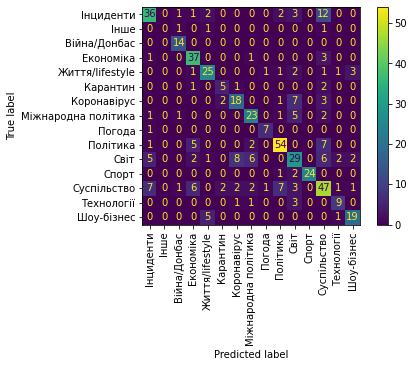

/Users/oksana/Dev/TextClassification/venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/oksana/Dev/TextClassification/venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-l

F1_score: 0.6791556878247624
CV_score: 0.7387509947233889


/Users/oksana/Dev/TextClassification/venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [18]:
model, predicted = test_model(stacking, X_train_vec, X_test_vec, y_train, y_test)
# SGDClassifier()
# LinearSVC()
# MLPClassifier
# MultinomialNB
# LogisticRegression
# RandomForestClassifier
# KNeighborsClassifier
# PassiveAggressiveClassifier

In [17]:
models = [('pa', PassiveAggressiveClassifier()),('svm',LinearSVC())]
stacking = StackingClassifier(estimators=models)

## Find best model parameters with GridSearchCV

In [15]:
parameters = {'C':[1, 5, 10, 20], 'class_weight':['balanced', None]}
svc = LinearSVC()
clf = GridSearchCV(svc, parameters, n_jobs=-1)
clf.fit(X_train_vec, y_train)
print(clf.best_params_)

final_model = clf.best_estimator_
train_predictions = final_model.predict(X_train_vec)
test_predictions = final_model.predict(X_test_vec)

print('Test Score:', f1_score(test_predictions, y_test, average = 'weighted'))

{'C': 1, 'class_weight': None}
Test Score: 0.6862021258527589


In [ ]:
pipeline = Pipeline([
    ('vect', TfidfVectorizer(tokenizer = lambda text: my_tokenizer(text, **stem_ukr))),
    ('tfidf', TfidfTransformer()),
    ('clf', LinearSVC()),
])


parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1, 1), (1, 2)),  
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clf__C': (1, 5, 10, 20),
    'clf__penalty': ('l2', 'elasticnet'),
    'clf__max_iter': (1000, 2000),
}


grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
pprint(parameters)
t0 = time()
grid_search.fit(X_train, y_train)
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))